In [1]:
from google.colab import drive
drive.mount('/content/drive')
datadir = "/content/"
save_dir = "/content/drive/My Drive/CS441_Project"

Mounted at /content/drive


In [2]:
import pandas as pd

save_dir = "/content/drive/My Drive/CS441_Project"

files = [
    "Intake and Outcome 11-1-21 through 10-31-22.xlsx",
    "Intake and Outcome 11-1-22 through 10-31-23.xlsx",
    "Intake and Outcome 11-1-23 through 10-31-24.xlsx",
    "Intake and Outcome 11-1-24 through 10-31-25.xlsx",
]

dfs = [pd.read_excel(save_dir + "/" + f) for f in files]

df = pd.concat(dfs, ignore_index=True)
df.columns



Index(['Animal ID', 'Animal Name', 'Species', 'Primary Breed',
       'Secondary Breed', 'Date of Birth', 'Age Group at Intake',
       'Current Status', 'Intake Date', 'Intake Type', 'Outcome Date',
       'Outcome Type', 'Days in Custody', 'Days Onsite', 'Days Available'],
      dtype='object')

Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Processed 0/53349 samples
Processed 3200/53349 samples
Processed 6400/53349 samples
Processed 9600/53349 samples
Processed 12800/53349 samples
Processed 16000/53349 samples
Processed 19200/53349 samples
Processed 22400/53349 samples
Processed 25600/53349 samples
Processed 28800/53349 samples
Processed 32000/53349 samples
Processed 35200/53349 samples
Processed 38400/53349 samples
Processed 41600/53349 samples
Processed 44800/53349 samples
Processed 48000/53349 samples
Processed 51200/53349 samples
Embeddings shape:  (53349, 768)
Train size: 37344
Val size: 8002
Test size: 8003
Validation Accuracy: 0.7686828292926768
Test Accuracy: 0.7594652005497938


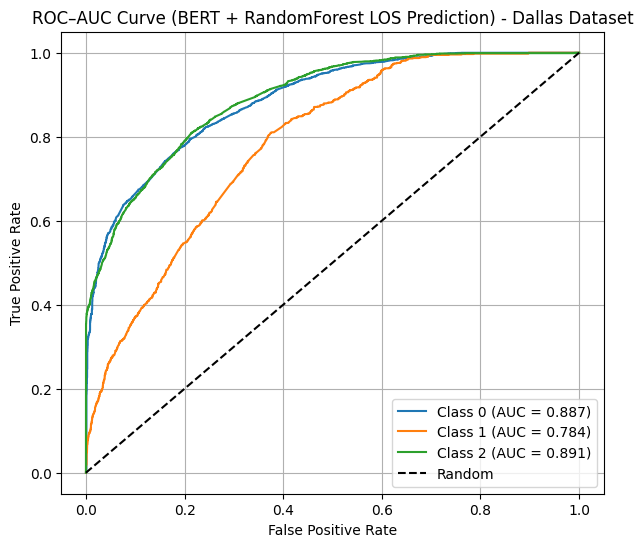

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import torch
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
df = pd.read_csv(save_dir + "/Dallas_Animal_Shelter.csv", low_memory=False)
df = df.fillna("Unknown")
df = df[df["Animal_Type"] == "DOG"]
df["Intake_Date"]=pd.to_datetime(df["Intake_Date"],errors="coerce")
df["Outcome_Date"]=pd.to_datetime(df["Outcome_Date"],errors="coerce")
df["LOS_days"]=(df["Outcome_Date"] - df["Intake_Date"]).dt.days
df = df[(df["LOS_days"].notnull()) & (df["LOS_days"] >= 0)]

def los_to_class(los):
    if los <= 7:
        return 0
    elif los <= 14:
        return 1
    else:
        return 2

df["LOS_class"] = df["LOS_days"].apply(los_to_class)

def row_to_text(row):
    return (
        f"Dog is a {row['Animal_Breed']} breed. "
        f"Intake type was {row['Intake_Type']} with subtype {row['Intake_Subtype']}. "
        f"Reason for intake was {row['Reason']}. "
        f"Intake condition was {row['Intake_Condition']}. "
        f"Outcome type: {row['Outcome_Type']} with subtype {row['Outcome_Subtype']}. "
        f"Hold request: {row['Hold_Request']}. "
        f"Chip status: {row['Chip_Status']}. "
        f"Origin: {row['Animal_Origin']}."
    )

df["text_input"] = df.apply(row_to_text,axis=1)
texts = df["text_input"].tolist()
labels = df["LOS_class"].values

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased")
bert = bert.to(device)
bert.eval()

def get_bert_embeddings_batch(text_list, batch_size=16):
    all_embs = []

    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i+batch_size]

        encoded = tokenizer(batch,return_tensors="pt",truncation=True,padding=True,max_length=128).to(device)

        with torch.no_grad():
            output = bert(**encoded)

        cls_emb = output.last_hidden_state[:, 0, :].cpu().numpy()
        all_embs.append(cls_emb)

        if i%(batch_size*200)==0:
            print(f"Processed {i}/{len(text_list)} samples")

    return np.vstack(all_embs)

embeddings = get_bert_embeddings_batch(texts, batch_size=16)
print("Embeddings shape: ", embeddings.shape)

X_train,X_remain,y_train,y_remain = train_test_split(embeddings,labels,test_size=0.30,random_state=42,stratify=labels)

X_val,X_test,y_val,y_test = train_test_split(X_remain,y_remain,test_size=0.50,random_state=42,stratify=y_remain)

print("Train size:", len(X_train))
print("Val size:", len(X_val))
print("Test size:", len(X_test))

rf = RandomForestClassifier(n_estimators=300,max_depth=25,n_jobs=-1,random_state=42)
rf.fit(X_train, y_train)
val_preds = rf.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, val_preds))
test_preds = rf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, test_preds))

test_probs = rf.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(7, 6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], test_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,tpr,label=f"Class {i} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC–AUC Curve (BERT + RandomForest LOS Prediction) - Dallas Dataset")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 2334/2334 [15:37<00:00,  2.49it/s]


Epoch 1 - Training Loss: 0.6104
Validation Accuracy: 0.7686828292926768


100%|██████████| 2334/2334 [15:37<00:00,  2.49it/s]


Epoch 2 - Training Loss: 0.5529
Validation Accuracy: 0.7740564858785304


100%|██████████| 2334/2334 [15:38<00:00,  2.49it/s]


Epoch 3 - Training Loss: 0.5356
Validation Accuracy: 0.7786803299175207
Test Accuracy: 0.772585280519805


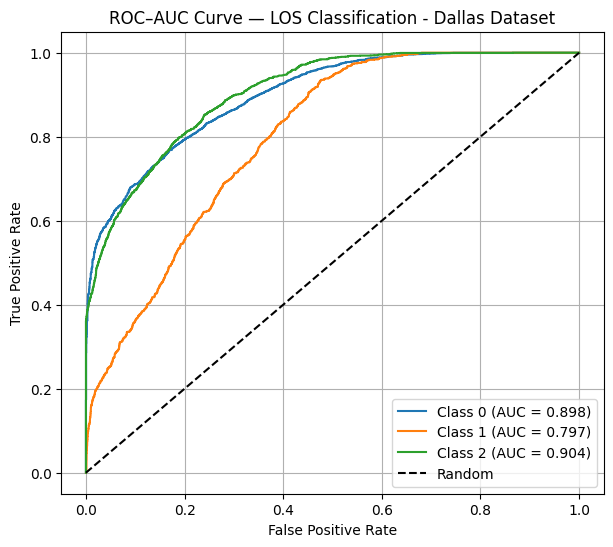

In [5]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from torch.optim import AdamW
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

df = pd.read_csv(save_dir + "/Dallas_Animal_Shelter.csv", low_memory=False)
df = df.fillna("Unknown")
df = df[df["Animal_Type"] == "DOG"]
df["Intake_Date"] = pd.to_datetime(df["Intake_Date"], errors="coerce")
df["Outcome_Date"] = pd.to_datetime(df["Outcome_Date"], errors="coerce")
df["LOS_days"] = (df["Outcome_Date"] - df["Intake_Date"]).dt.days
df = df[(df["LOS_days"].notnull()) & (df["LOS_days"] >= 0)]

def los_to_class(los):
    if los <= 7:
        return 0
    elif los <= 14:
        return 1
    else:
        return 2

df["LOS_class"] = df["LOS_days"].apply(los_to_class)


def row_to_text(row):
    return (
        f"Dog is a {row['Animal_Breed']} breed. "
        f"Intake type was {row['Intake_Type']} with subtype {row['Intake_Subtype']}. "
        f"Reason for intake was {row['Reason']}. "
        f"Intake condition was {row['Intake_Condition']}. "
        f"Outcome type was {row['Outcome_Type']} with subtype {row['Outcome_Subtype']}. "
        f"Outcome condition at outcome was {row['Outcome_Condition']}. "
        f"Hold request: {row['Hold_Request']}. "
        f"Origin: {row['Animal_Origin']}. "
        f"Intake month and year: {row['Month']} in {row['Year']}. "
        f"Council district: {row['Council_District']}."
    )

df["text_input"] = df.apply(row_to_text, axis=1)

texts = df["text_input"].tolist()
labels = df["LOS_class"].values

X_train, X_temp, y_train, y_temp = train_test_split(texts, labels, test_size=0.30, random_state=42, stratify=labels)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class LOSDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
            encoded = tokenizer(
                self.texts[idx],
                truncation=True,
                padding="max_length",
                max_length=128,
                return_tensors="pt"
            )
            item = {key: val.squeeze(0) for key, val in encoded.items()}
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
            return item

train_ds = LOSDataset(X_train, y_train)
val_ds = LOSDataset(X_val, y_val)
test_ds = LOSDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)
test_loader = DataLoader(test_ds, batch_size=16)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=3)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 3
total_steps = len(train_loader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=100,num_training_steps=total_steps)

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} - Training Loss: {total_loss / len(train_loader):.4f}")

    model.eval()
    preds = []
    true = []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)

            logits = outputs.logits
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true.extend(batch["labels"].cpu().numpy())

    print("Validation Accuracy:", accuracy_score(true, preds))

model.eval()

test_probs = []
test_true = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)

        test_probs.append(probs.cpu().numpy())
        test_true.extend(batch["labels"].cpu().numpy())

test_probs = np.vstack(test_probs)
test_true = np.array(test_true)
test_preds = np.argmax(test_probs, axis=1)
print("Test Accuracy:", accuracy_score(test_true, test_preds))

y_test_bin = label_binarize(test_true, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]
plt.figure(figsize=(7, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], test_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,tpr,label=f"Class {i} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC–AUC Curve — LOS Classification - Dallas Dataset")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 99/99 [00:39<00:00,  2.53it/s]


Epoch 1 - Training Loss: 0.9299
Val Accuracy: 0.7952522255192879


100%|██████████| 99/99 [00:37<00:00,  2.61it/s]


Epoch 2 - Training Loss: 0.5735
Val Accuracy: 0.8130563798219584


100%|██████████| 99/99 [00:38<00:00,  2.58it/s]


Epoch 3 - Training Loss: 0.4493
Val Accuracy: 0.8308605341246291
Test Accuracy: 0.8195266272189349
Macro ROC-AUC: 0.8883


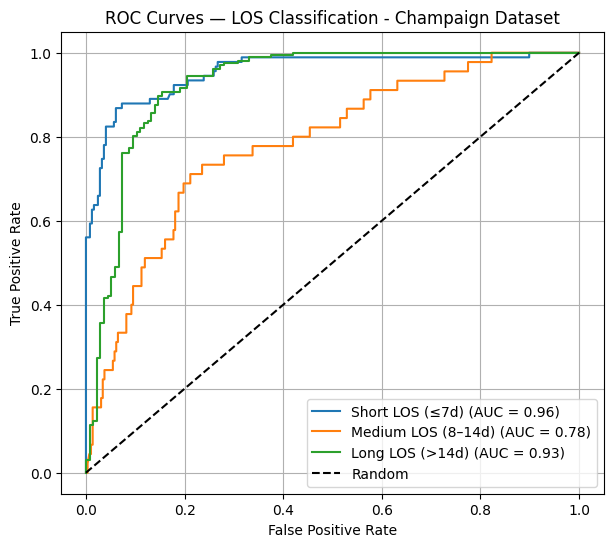

In [6]:
import pandas as pd
import numpy as np
import re
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from torch.optim import AdamW
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

save_dir = "/content/drive/My Drive/CS441_Project"

files = [
    "Intake and Outcome 11-1-21 through 10-31-22.xlsx",
    "Intake and Outcome 11-1-22 through 10-31-23.xlsx",
    "Intake and Outcome 11-1-23 through 10-31-24.xlsx",
    "Intake and Outcome 11-1-24 through 10-31-25.xlsx",
]

dfs = [pd.read_excel(save_dir + "/" + f) for f in files]
df = pd.concat(dfs, ignore_index=True)
df = df[df["Species"] == "Dog"].copy()
df = df.fillna("Unknown")

df["Intake_Date"] = pd.to_datetime(df["Intake Date"], errors="coerce")
df["Outcome_Date"] = pd.to_datetime(df["Outcome Date"], errors="coerce")
df["Date_of_Birth"] = pd.to_datetime(df["Date of Birth"], errors="coerce")

df["LOS_days"] = (df["Outcome_Date"] - df["Intake_Date"]).dt.days
df = df[(df["LOS_days"].notnull()) & (df["LOS_days"] >= 0)]

def los_to_class(los):
    if los <= 7:
        return 0
    elif los <= 14:
        return 1
    else:
        return 2

df["LOS_class"] = df["LOS_days"].apply(los_to_class)

def parse_age_group(text):
    text = str(text).lower()
    matches = re.findall(r"(\d+)\s*(weeks?|months?|years?)", text)
    if not matches:
        nums = re.findall(r"(\d+)", text)
        if not nums:
            return np.nan
        vals = [int(n) for n in nums]
        return float(np.mean(vals))

    vals_months = []
    for num_str, unit in matches:
        n = int(num_str)
        if "week" in unit:
            vals_months.append(n / 4.0)
        elif "year" in unit:
            vals_months.append(n * 12.0)
        else:
            vals_months.append(float(n))

    return float(np.mean(vals_months)) if vals_months else np.nan

age_months_dob = (df["Intake_Date"] - df["Date_of_Birth"]).dt.days / 30.44
age_months_group = df["Age Group at Intake"].apply(parse_age_group)
df["AgeMonths"] = np.where(age_months_dob.notnull(), age_months_dob, age_months_group)
df["AgeMonths"] = df["AgeMonths"].fillna(0.0)
df["Intake_Month"] = df["Intake_Date"].dt.month.astype("Int64").astype(str)
df["Outcome_Month"] = df["Outcome_Date"].dt.month.astype("Int64").astype(str)

def build_text(row):
    if row["Secondary Breed"] != "Unknown":
        breed_desc = f"{row['Primary Breed']} and {row['Secondary Breed']} mix"
    else:
        breed_desc = row["Primary Breed"]

    return (
        f"Dog: {breed_desc}. "
        f"Approximate age at intake: {row['AgeMonths']:.1f} months "
        f"(age group: {row['Age Group at Intake']}). "
        f"Intake type: {row['Intake Type']} in month {row['Intake_Month']}. "
        f"Outcome type: {row['Outcome Type']} in month {row['Outcome_Month']}. "
    )

df["text_input"] = df.apply(build_text, axis=1)

texts = df["text_input"].tolist()
labels = df["LOS_class"].values

X_train, X_temp, y_train, y_temp = train_test_split(texts, labels, test_size=0.30, stratify=labels, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class LOSDogsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded = tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in encoded.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_ds = LOSDogsDataset(X_train, y_train)
val_ds   = LOSDogsDataset(X_val,   y_val)
test_ds  = LOSDogsDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=16)
test_loader  = DataLoader(test_ds,  batch_size=16)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=3)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 3
total_steps = len(train_loader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=100,num_training_steps=total_steps)

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} - Training Loss: {total_loss / len(train_loader):.4f}")

    model.eval()
    preds, true = [], []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            logits = model(**batch).logits
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true.extend(batch["labels"].cpu().numpy())

    print("Val Accuracy:", accuracy_score(true, preds))

model.eval()

test_probs = []
test_preds = []
test_true = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        test_probs.extend(probs.cpu().numpy())
        test_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        test_true.extend(batch["labels"].cpu().numpy())

test_probs = np.array(test_probs)
test_preds = np.array(test_preds)
test_true = np.array(test_true)
print("Test Accuracy:", accuracy_score(test_true, test_preds))

num_classes = 3
test_true_bin = label_binarize(test_true, classes=[0, 1, 2])
macro_auc = roc_auc_score(test_true_bin,test_probs,average="macro",multi_class="ovr")
print(f"Macro ROC-AUC: {macro_auc:.4f}")

plt.figure(figsize=(7, 6))
class_names = ["Short LOS (≤7d)", "Medium LOS (8–14d)", "Long LOS (>14d)"]

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(test_true_bin[:, i], test_probs[:, i])
    auc_i = roc_auc_score(test_true_bin[:, i], test_probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc_i:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — LOS Classification - Champaign Dataset")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

